In [1]:
import os
import json
import pandas as pd
import numpy as np
import tqdm
import scipy.sparse as sp

from pprint import pprint

In [2]:
pd.set_option('display.max_columns',100)

In [3]:
DATA_PATH = '../okko/orig_data'

In [4]:
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)
    
catalogue = {int(k): v for k, v in catalogue.items()}

In [5]:
pprint(catalogue[100])

{'attributes': [18441,
                16300,
                16580,
                18770,
                18771,
                18643,
                396,
                18772,
                3771,
                18773,
                910,
                18774,
                16364,
                3277],
 'availability': ['purchase', 'rent'],
 'duration': 80,
 'feature_1': 6064738.740195342,
 'feature_2': 0.752750538,
 'feature_3': 4,
 'feature_4': 0.9537104605,
 'feature_5': 0.0,
 'type': 'movie'}


 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1,2,4,5` —  анонимизированные вещественные признаки, `feature_3` - порядковый
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
s = [','.join([str(i) for i in catalogue[100]['attributes']])]
s1 = [','.join([str(i) for i in catalogue[10]['attributes']])]
print(s,s1)
cv = CountVectorizer(token_pattern='\d+')
print(cv.fit_transform([*s,*s1]).todense())


['18441,16300,16580,18770,18771,18643,396,18772,3771,18773,910,18774,16364,3277'] ['10511,2752,9076,1373,472,7,10512,42,43,10513,25']
[[0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0]]


In [8]:
# Сделаем мешок атрибутов для каждого фильма
bag_of_attr = {}
map_type = {'movie':2,'multipart_movie':2,'series':3}
buf = []
ind = []
bag = []
for key,cat in tqdm.tqdm(catalogue.items()):
    
    bag_of_attr[int(key)]= ','.join([str(i) for i in cat['attributes']])
    bag.append((','.join([str(i) for i in cat['attributes']])))
    buf.append([1*('purchase' in cat['availability']), 1*('rent' in cat['availability']),1*('subscription' in cat['availability']),
               cat['duration'],cat['feature_1'],cat['feature_2'],cat['feature_3'],cat['feature_4'],cat['feature_5'],
               cat['type']])
    ind.append(int(key))
data_catalogue = pd.DataFrame(buf,columns = ['is_purchase','is_rent','is_subscription','duration','feature_1',
                                            'feature_2','feature_3','feature_4','feature_5','type'],index = ind)
data_catalogue['type'] = data_catalogue['type'].map(map_type)
cv = CountVectorizer(token_pattern='\d+',)
X = cv.fit_transform(bag)
#bag_of_attr = pd.DataFrame(X.todense(),columns = cv.get_feature_names(),index = ind)

100%|██████████| 10200/10200 [00:00<00:00, 121005.96it/s]


In [9]:
data_catalogue.head()

,is_purchase,is_rent,is_subscription,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type
1983,1,1,1,140,1.657223e+06,0.753610,39,1.119409,0.000000,2
3783,1,1,1,110,3.556521e+07,0.766254,41,1.138604,0.654707,2
5208,1,1,1,90,1.327068e+07,0.765425,27,1.131807,0.592716,2
9744,1,1,1,120,2.174992e+07,0.757874,26,1.133525,0.654707,2
1912,1,1,0,110,9.212964e+06,0.759566,7,1.110127,0.654707,2


In [10]:
#bag_of_attr.describe()
#bag_of_attr.shape

In [11]:
%%time
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)

CPU times: user 4 s, sys: 135 ms, total: 4.13 s
Wall time: 4.13 s


In [12]:
%%time
ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)

CPU times: user 124 ms, sys: 8 ms, total: 132 ms
Wall time: 131 ms


In [13]:
ratings.iloc[100]

user_uid       2.078610e+05
element_uid    2.714000e+03
rating         1.000000e+01
ts             4.430376e+07
Name: 100, dtype: float64

In [14]:
%%time
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

CPU times: user 251 ms, sys: 4.33 ms, total: 255 ms
Wall time: 255 ms


In [15]:
#Попробуем для каждого пользователя сделать некоторый путь потребления контента
# Для этого объединим все действия пользователей
transactions['action'] = 'watch'
ratings['action'] = 'rate'
bookmarks['action'] = 'bookmate'

In [16]:
bookmarks.iloc[100]

user_uid            559099
element_uid            943
ts             4.43041e+07
action            bookmate
Name: 100, dtype: object

In [17]:
actions = pd.concat((transactions,ratings,bookmarks))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
actions.head()

,action,consumption_mode,device_manufacturer,device_type,element_uid,rating,ts,user_uid,watched_time
0,watch,S,50.0,0.0,3336,NaN,4.430518e+07,5177,4282.0
1,watch,S,11.0,0.0,481,NaN,4.430518e+07,593316,2989.0
2,watch,S,50.0,0.0,4128,NaN,4.430518e+07,262355,833.0
3,watch,S,99.0,0.0,6272,NaN,4.430518e+07,74296,2530.0
4,watch,P,50.0,0.0,5543,NaN,4.430518e+07,340623,6282.0


`consumption_mode` — тип потребления (переменная принимает следующие значения: P — покупка, R — аренда, S — просмотр по подписке)

In [19]:
actions.set_index(['user_uid','element_uid','ts'],inplace = True)

In [20]:
actions.sort_index(inplace = True)

In [21]:
one_user = actions.loc[207861]

In [22]:
one_user

action consumption_mode  device_manufacturer  \
element_uid ts                                                          
1570        4.357572e+07   rate              NaN                  NaN   
            4.357628e+07  watch                R                 50.0   
2714        4.430346e+07  watch                R                 50.0   
            4.430376e+07   rate              NaN                  NaN   
3336        4.335158e+07   rate              NaN                  NaN   
            4.335240e+07  watch                P                 50.0   

                          device_type  rating  watched_time  
element_uid ts                                               
1570        4.357572e+07          NaN    10.0           NaN  
            4.357628e+07          0.0     NaN        6229.0  
2714        4.430346e+07          0.0     NaN        8088.0  
            4.430376e+07          NaN    10.0           NaN  
3336        4.335158e+07          NaN    10.0           NaN  
            4.335240e+07          0.0     NaN        5839.0

In [23]:
data_catalogue.index.names = ['element_uid',]

In [24]:
data_catalogue['duration'] = data_catalogue['duration']*60

In [25]:
data_catalogue.head()

,is_purchase,is_rent,is_subscription,duration,feature_1,feature_2,feature_3,feature_4,feature_5,type
element_uid,,,,,,,,,,
1983,1,1,1,8400,1.657223e+06,0.753610,39,1.119409,0.000000,2
3783,1,1,1,6600,3.556521e+07,0.766254,41,1.138604,0.654707,2
5208,1,1,1,5400,1.327068e+07,0.765425,27,1.131807,0.592716,2
9744,1,1,1,7200,2.174992e+07,0.757874,26,1.133525,0.654707,2
1912,1,1,0,6600,9.212964e+06,0.759566,7,1.110127,0.654707,2


In [26]:
#data_catalogue.loc[1570]

actions = actions.join(data_catalogue[['duration','type']])#.loc[(slice(None),[1570,],slice(None)),:]

In [27]:
#actions.rating.value_counts()

In [28]:
with open(os.path.join(DATA_PATH, 'test_users.json'), 'r') as f:
    test_users = set(json.load(f)['users'])

In [29]:
len(test_users & set(actions.index.get_level_values(0)))

50000

In [30]:
# Приделаем каждому чуваку атрибуты просмотренных фильмов. ну или вообще по всем действиям - они все позитивные
ind_user = []
buf = []
for i in tqdm.tqdm(np.unique(actions.index.get_level_values(0))):
    temp = np.unique(actions.loc[i].index.get_level_values(0))
    ind_user.append(i)
    
    s = ''
    for ii in temp:
        s+=bag_of_attr[ii]
        
        s+=','
    if  '26846' in s:
            break
    #assert X.shape[1] == len(a)
    buf.append(s)
    
    

100%|██████████| 500000/500000 [04:38<00:00, 1798.42it/s]


In [31]:
s

'4052,4127,4128,4129,270,4130,4131,1241,42,14,15,131,170,33,17,328,272,25,30100,25237,6710,25123,270,17516,130,10,138,14,15,131,17,18,19,328,272,197,25,8392,22288,7859,13295,83,571,22289,43,14,15,131,17,18,19,21,44,361,25,5278,7903,7904,7905,7,7906,123,42,14,15,17,18,19,20,21,56,25,35239,270,35314,1134,14,15,1135,3704,6634,6635,4389,270,6636,130,42,14,15,131,17,18,19,328,272,25,10052,11766,4389,6781,270,11767,43,14,15,17,18,19,328,272,20,44,25,8380,11756,10050,270,30435,43,14,15,131,17,18,19,328,272,44,25,716,10220,559,1317,714,367,1279,7,20411,31,43,14,15,131,17,18,19,21,44,25,5043,638,396,21837,1492,14,15,3273,16,3274,3275,18327,21840,11935,679,2315,4350,7,11936,11937,43,14,15,131,17,18,19,21,25,59,5133,5134,5135,1055,7,699,42,43,124,14,15,18,19,20,21,5136,5137,25,9714,5043,9737,9738,396,9718,1492,14,15,3273,16,6478,6479,3277,1065,198,1066,660,7,1067,31,54,175,14,15,131,17,18,19,21,25,35287,577,270,35288,1492,14,15,3273,25,34916,34917,34918,34919,34920,577,34846,1492,14,15,3273,22971

In [32]:
cv1 = CountVectorizer(token_pattern='\d+',)
X_user = cv1.fit_transform(buf)

In [33]:
X_user.shape

(500000, 33465)

In [34]:
X.shape

(10200, 35869)

In [35]:
# Дальше уже совершенно ненужная херь, запускать до сюда


In [36]:
len(cv1.get_feature_names())

33465

In [37]:
actions.head(20)#groupby('type')['duration'].median()/60


action consumption_mode  \
user_uid element_uid ts                                     
0        51          4.416546e+07  watch                S   
         72          4.375829e+07  watch                S   
         207         4.371904e+07  watch                S   
         209         4.377814e+07  watch                S   
         434         4.338109e+07  watch                S   
         460         4.333750e+07  watch                S   
         603         4.419977e+07  watch                S   
         893         4.372807e+07  watch                S   
         944         4.343746e+07  watch                S   
         1016        4.336596e+07  watch                S   
         1165        4.338014e+07  watch                S   
         1176        4.382874e+07  watch                S   
         1253        4.379047e+07  watch                S   
         1284        4.333743e+07  watch                S   
         1535        4.333747e+07  watch                S   
         1550        4.364514e+07  watch                S   
         1911        4.388547e+07  watch                S   
         1974        4.403384e+07  watch                S   
         1983        4.335460e+07  watch                S   
         2081        4.340841e+07  watch                S   

                                   device_manufacturer  device_type  rating  \
user_uid element_uid ts                                                       
0        51          4.416546e+07                 99.0          0.0     NaN   
         72          4.375829e+07                 99.0          0.0     NaN   
         207         4.371904e+07                 99.0          0.0     NaN   
         209         4.377814e+07                 99.0          0.0     NaN   
         434         4.338109e+07                 99.0          0.0     NaN   
         460         4.333750e+07                 99.0          0.0     NaN   
         603         4.419977e+07                 99.0          0.0     NaN   
         893         4.372807e+07                 99.0          0.0     NaN   
         944         4.343746e+07                 99.0          0.0     NaN   
         1016        4.336596e+07                 99.0          0.0     NaN   
         1165        4.338014e+07                 99.0          0.0     NaN   
         1176        4.382874e+07                 99.0          0.0     NaN   
         1253        4.379047e+07                 99.0          0.0     NaN   
         1284        4.333743e+07                 99.0          0.0     NaN   
         1535        4.333747e+07                 99.0          0.0     NaN   
         1550        4.364514e+07                 99.0          0.0     NaN   
         1911        4.388547e+07                 99.0          0.0     NaN   
         1974        4.403384e+07                 99.0          0.0     NaN   
         1983        4.335460e+07                 99.0          0.0     NaN   
         2081        4.340841e+07                 99.0          0.0     NaN   

                                   watched_time  duration  type  
user_uid element_uid ts                                          
0        51          4.416546e+07       12382.0      3600     2  
         72          4.375829e+07        5653.0      6000     2  
         207         4.371904e+07        2646.0      5400     2  
         209         4.377814e+07        6971.0      7200     2  
         434         4.338109e+07        5894.0      6600     2  
         460         4.333750e+07         240.0      7200     2  
         603         4.419977e+07           0.0      5400     2  
         893         4.372807e+07        5773.0      6600     2  
         944         4.343746e+07         362.0      5400     2  
         1016        4.336596e+07        6732.0      6600     2  
         1165        4.338014e+07        3366.0      6600     2  
         1176        4.382874e+07        6010.0      6000     2  
         1253        4.37904

In [38]:
# actions.device_manufacturer.value_counts()

In [39]:
actions.consumption_mode.value_counts()

S    8296227
P     873834
R     472951
Name: consumption_mode, dtype: int64

2 - фильм, 3 - сериал

Считается, что пользователь потребил контент, если он:
1. Купил его или взял в аренду
2. Посмотрел больше половины фильма по подписке
3. Посмотрел больше трети сериала по подписке


In [40]:
actions.action.value_counts()

watch       9643012
bookmate     948216
rate         438790
Name: action, dtype: int64

In [41]:
%matplotlib inline

In [42]:
def get_target(actions):
    '''
    Функция, которая вернет число просмотреннх серий каждым пользователем каждого сериала, потом вернет то,что недопотребил
    А потом то, что точно потребил согласно правилам соревнования - например, так можно вычислить примерную длительность сериала 
    и его же рекомендовать в потребленные после.
    '''
    watch_actions = actions[actions.action == 'watch']
    # Блок нахождения всяких статистик по сериалам
    serials = watch_actions[watch_actions['type'] == 3]
    # Заменим длиетльность на 0, там где длительности нет.. или это очень короткие, надо подумоть.
    serials['num_of_series'] = (serials['watched_time']/serials['duration']).fillna(0).replace(np.inf,0).astype(int)
    serials['time_being'] = serials.index.get_level_values(2)
    dur_being = serials.groupby(level = 1).agg({'time_being':[min,len],'num_of_series':[lambda x:x.mode()[0],max]})
    dur_being.columns = ['time_being','count_of_watch','num_of_series_mode','num_of_series_max']
    
    # Блок нахождения статистик по фильмам для пользователя
    films = watch_actions[watch_actions['type'] == 2]
    # Здесь важно видимо, как долго смотрел
    films['time_being'] = films.index.get_level_values(2)
    dur_films = films.groupby(level = 1).agg({'time_being':[min,len]})
    dur_films.columns = ['time_being','count_of_watch']
    
    # Блок нахождения статистик по фильмам и пользователям
    watch_actions['rel_dur'] = (watch_actions['watched_time']/watch_actions['duration'])
    watch_actions = watch_actions.groupby(level = [0,1]).mean()
    
    
    return dur_being,dur_films,watch_actions

In [43]:
dur_being,dur_films,watch_actions = get_target(actions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

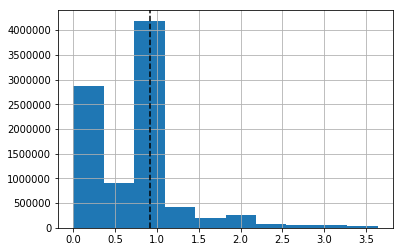

In [66]:
# как там интересно распределно.
a = watch_actions['rel_dur'].replace(np.inf,-1,).fillna(-1)
ax = a[(np.percentile(a,1)<a) & (np.percentile(a,95)>=a) ].hist()
ax.axvline(x=np.median(a), color='k', linestyle='--')

In [67]:
#  я б сказал, что это как-то некоторая окрестность единицы (мб по перцентилям - но тут надо подумать)- в ней фильмы просмотрены.
# За этой окрестностью справа - либо многосерийники, либо какая-то дичь
# слева - точно недосмотры.
# Можно попробовтаь какую-нить простую линейную модельку от атрибутов на 3 класса,( как вариант - регрессия просто)
# чтобы потом на коэффициенты взвесить атрибуты для полдьзователя (X_user)
#  а для фильмов - доля просмотров и недосмотров пользователям

In [114]:
# Просто находит некоторые новинки и возвращает их  id
# Критерий скорее всего такой - строим ряд просмотров - 
# если их много прям с первой даты и дата не в начале списка - то новинка.
def min_nnz(x):
    if len(x[x!=0]) >0:
        return min(x[x!=0])
    else:
        return -1
def novice_detect(actions):
    watch_actions = actions[actions.action == 'watch']
    
    by_movie = watch_actions.groupby(level = [1,2])['action'].count().to_frame()
    by_movie.columns = ['by_time']
    al = watch_actions.groupby(level = [1])['action'].count().to_frame()
    by_movie = by_movie.join(al)
    by_movie['ts_time'] = by_movie.index.get_level_values(1)
    by_movie.sort_index(inplace = True)
    being_time = by_movie.groupby(level = [0])['ts_time'].agg(lambda x: x.iloc[0]).to_frame()
    being_time.columns = ['first_time']
    by_movie = by_movie.join(being_time)
    by_movie['diff_time'] = by_movie['ts_time'] - by_movie['first_time']
    by_movie['cum_watch'] = by_movie.groupby(level = [0,1])['by_time'].sum().groupby(level = 0).cumsum()
    by_movie['detect'] = by_movie['diff_time']/by_movie['cum_watch']
    res = by_movie.groupby(level = 0)['detect'].agg([min_nnz,max,np.mean,np.median])
    return res

In [115]:
a = novice_detect(actions)

In [116]:
#a.index = a.index.swaplevel()

In [117]:
#a['cum_watch'] = a.groupby(level = [0,1])['by_time'].sum().groupby(level = 0).cumsum()

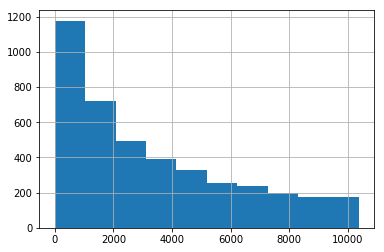

In [129]:
#a.loc[a['min_nnz'] !=-1,'min_nnz'].hist()
ax = a.loc[a['mean']<np.median(a['mean']),'mean'].hist()
#ax.axvline(x=np.median(a['mean']), color='k', linestyle='--')

In [130]:
# Вот тут надо подумать, что б такое было бы. что поможет детектировать новинки.
# Кажется, что их средние накопленные просмотры дб маленикими
# Только надо подумать

In [127]:
a[a['min_nnz']!=-1].sort_values('mean').iloc[:100]

,min_nnz,max,mean,median
element_uid,,,,
2714,0.000972,28.662490,9.502836,7.597770
747,0.001134,38.348577,12.549593,8.872544
9179,0.000778,33.537973,13.656945,10.291293
5616,3.200668,44.761548,14.923060,10.293241
10073,0.000081,44.308264,15.418492,10.960653
5798,8.242134,73.262675,21.290493,15.979399
9657,0.000729,60.753041,22.401472,17.393524
9077,0.000418,61.276176,23.544972,19.515574
9932,0.001853,80.398751,26.050574,18.820537


In [ ]:
len(cv.get_feature_names())

In [ ]:
len(set(cv1.get_feature_names())^set(cv.get_feature_names()))

In [ ]:
set(cv.get_feature_names())^set(cv1.get_feature_names())

In [ ]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

# Load the MovieLens 100k dataset. Only five
# star ratings are treated as positive.
data = fetch_movielens(min_rating=5.0)

# Instantiate and train the model
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

# Evaluate the trained model
test_precision = precision_at_k(model, data['test'], k=5).mean()